# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
!pip install timm

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [5]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'data/'

# model config
model_name = 'efficientnet_b2'

# training config
img_size = 260
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0
log_interval = 100

In [6]:
'''# one epoch 학습을 위한 함수입니다.
def train_one_epoch(epoch, loader, model, optimizer, loss_fn):
    preds_list = []
    targets_list = []

    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        current_loss = 0.0
        current_correct = 0.0

        # Forward 
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, labels)

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds_list.extend(preds.detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())

        current_loss += loss.item()

        if batch_idx % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = accuracy_score(targets_list, preds_list)
            train_f1 = f1_score(targets_list, preds_list, average='macro')

            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}, Train Acc: {:.4f}, Train F1 Score: {:.4f}".format(
                epoch,
                batch_idx * len(images), 
                len(loader) * len(images), 
                100 * batch_idx / len(loader), 
                train_loss, 
                train_acc,
                train_f1))
           
    return current_loss / len(loader), accuracy_score(targets_list, preds_list), f1_score(targets_list, preds_list, average='macro')
  

def validation(model, val_loader, loss_fn):
    val_preds_list = []
    val_targets_list = []
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0.0
        model.eval()

        for val_idx, (val_images, val_labels) in enumerate(val_loader):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            
            val_preds_list.extend(val_preds.detach().cpu().numpy())
            val_targets_list.extend(val_labels.detach().cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = accuracy_score(val_targets_list, val_preds_list)
        val_epoch_f1 = f1_score(val_targets_list, val_preds_list, average='macro')

        print("Validation dataset: Val Loss: {:.6f}, Val Acc: {:.4f}, Val F1 Score: {:.4f}".format(val_epoch_loss, val_epoch_acc, val_epoch_f1))
    return val_epoch_loss, val_epoch_acc, val_epoch_f1'''

'# one epoch 학습을 위한 함수입니다.\ndef train_one_epoch(epoch, loader, model, optimizer, loss_fn):\n    preds_list = []\n    targets_list = []\n\n    for batch_idx, (images, labels) in enumerate(loader):\n        images, labels = images.to(device), labels.to(device)\n\n        current_loss = 0.0\n        current_correct = 0.0\n\n        # Forward \n        outputs = model(images)\n        _, preds = torch.max(outputs, 1)\n\n        loss = loss_fn(outputs, labels)\n\n        # Back propagation\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        preds_list.extend(preds.detach().cpu().numpy())\n        targets_list.extend(labels.detach().cpu().numpy())\n\n        current_loss += loss.item()\n\n        if batch_idx % log_interval == 0:\n            train_loss = current_loss / log_interval\n            train_acc = accuracy_score(targets_list, preds_list)\n            train_f1 = f1_score(targets_list, preds_list, average=\'macro\')\n\n            print("Train

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [7]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [8]:
from torch.utils.data import random_split

In [9]:
# Dataset 정의
full_dataset = ImageDataset(
    "data/aug_train.csv", 
    "data/train/", 
    transform=trn_transform
)

dataset_size = len(full_dataset)

train_ratio = 0.8
val_ratio = 1 - train_ratio

train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size
trn_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

tst_dataset = ImageDataset(
    "data/sample_submission.csv",
    "data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

80384 3140


In [10]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [11]:
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)


        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret


def validate(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():
        for image, targets in loader:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)
            loss = loss_fn(preds, targets)
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())
    
    val_loss /= len(loader)
    val_acc = accuracy_score(targets_list, preds_list)
    val_f1 = f1_score(targets_list, preds_list, average='macro')
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

In [12]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Dataset, Subset
from torch import nn, optim

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='/data/ephemeral/home/efficientnetb2/checkpoint.pt', trace_func=print):
        """
        Early stopping을 위한 클래스 초기화
        patience: 성능 개선이 없는 에폭 수
        verbose: 메시지 출력 여부
        delta: 성능 개선으로 간주되기 위한 최소 변화량
        path: 모델 저장 경로
        trace_func: 로그 출력 함수
        """
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """
        검증 손실이 감소하면 모델을 저장
        """
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# 데이터셋 준비
dataset = trn_dataset

# K-Fold Cross-Validation 설정
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# 결과를 저장할 리스트 초기화
fold_results = []

# K-Fold Cross-Validation 시작
for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # DataLoader 정의
    train_subsampler = Subset(dataset, train_ids)
    valid_subsampler = Subset(dataset, valid_ids)
    train_loader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    # 모델 초기화
    model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    
    # 손실 함수와 최적화 방법 정의
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # Early Stopping 초기화
    early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.001, path=f'/data/ephemeral/home/efficientnetb2/fold_{fold}_checkpoint.pt')
    
    # 폴드별 훈련 및 검증 성능 기록
    fold_performance = {
        'train_acc': [],
        'train_f1': [],
        'val_acc': [],
        'val_f1': []
    }
    
    # 폴드별 훈련 및 검증
    for epoch in range(EPOCHS):
        # 훈련
        train_results = train_one_epoch(train_loader, model, optimizer, loss_fn, device)
        fold_performance['train_acc'].append(train_results['train_acc'])
        fold_performance['train_f1'].append(train_results['train_f1'])
        
        # 검증
        val_results = validate(valid_loader, model, loss_fn, device)
        fold_performance['val_acc'].append(val_results['val_acc'])
        fold_performance['val_f1'].append(val_results['val_f1'])
        
        early_stopping(val_results['val_loss'], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    model.load_state_dict(torch.load(f'/data/ephemeral/home/efficientnetb2/fold_{fold}_checkpoint.pt'))
    
    fold_results.append(fold_performance)
    print(f'Fold {fold} completed. Best val accuracy: {val_results["val_acc"]}, Best val F1 Score: {val_results["val_f1"]}\n')

# 최종 성능 계산 및 출력
train_accs = [np.mean(fold['train_acc']) for fold in fold_results]
train_f1s = [np.mean(fold['train_f1']) for fold in fold_results]
val_accs = [np.mean(fold['val_acc']) for fold in fold_results]
val_f1s = [np.mean(fold['val_f1']) for fold in fold_results]

print(f'Average Train Accuracy: {np.mean(train_accs)}, Average Train F1 Score: {np.mean(train_f1s)}')
print(f'Average Validation Accuracy: {np.mean(val_accs)}, Average Validation F1 Score: {np.mean(val_f1s)}')

FOLD 0
--------------------------------


  0%|          | 0/2010 [00:00<?, ?it/s]

Loss: 0.2247: 100%|██████████| 2010/2010 [09:23<00:00,  3.57it/s]


Validation loss decreased (inf --> 0.041387).  Saving model ...


Loss: 0.0001: 100%|██████████| 2010/2010 [09:08<00:00,  3.67it/s]


Validation loss decreased (0.041387 --> 0.016601).  Saving model ...


Loss: 0.1174: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0585: 100%|██████████| 2010/2010 [09:05<00:00,  3.69it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [09:08<00:00,  3.67it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0234: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.1021: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 5 out of 5
Early stopping
Fold 0 completed. Best val accuracy: 0.9932201281333582, Best val F1 Score: 0.9918514470343851

FOLD 1
--------------------------------


Loss: 0.0407: 100%|██████████| 2010/2010 [09:04<00:00,  3.69it/s]


Validation loss decreased (inf --> 0.036213).  Saving model ...


Loss: 0.0111: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


Validation loss decreased (0.036213 --> 0.021863).  Saving model ...


Loss: 0.0002: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0032: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0679: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


Validation loss decreased (0.021863 --> 0.015051).  Saving model ...


Loss: 0.0001: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


Validation loss decreased (0.015051 --> 0.009238).  Saving model ...


Loss: 0.0000: 100%|██████████| 2010/2010 [09:06<00:00,  3.68it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [09:09<00:00,  3.66it/s]


Validation loss decreased (0.009238 --> 0.005769).  Saving model ...


Loss: 0.0070: 100%|██████████| 2010/2010 [09:08<00:00,  3.67it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0511: 100%|██████████| 2010/2010 [09:08<00:00,  3.66it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0003: 100%|██████████| 2010/2010 [09:04<00:00,  3.69it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0006: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [09:08<00:00,  3.66it/s]


EarlyStopping counter: 5 out of 5
Early stopping
Fold 1 completed. Best val accuracy: 0.9977607762642284, Best val F1 Score: 0.9976684556183223

FOLD 2
--------------------------------


Loss: 0.0144: 100%|██████████| 2010/2010 [09:10<00:00,  3.65it/s]


Validation loss decreased (inf --> 0.029395).  Saving model ...


Loss: 0.0026: 100%|██████████| 2010/2010 [09:06<00:00,  3.68it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.1931: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0018: 100%|██████████| 2010/2010 [09:05<00:00,  3.69it/s]


Validation loss decreased (0.029395 --> 0.020323).  Saving model ...


Loss: 0.1164: 100%|██████████| 2010/2010 [09:06<00:00,  3.68it/s]


Validation loss decreased (0.020323 --> 0.015484).  Saving model ...


Loss: 0.0001: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


Validation loss decreased (0.015484 --> 0.010014).  Saving model ...


Loss: 0.0000: 100%|██████████| 2010/2010 [09:08<00:00,  3.67it/s]


Validation loss decreased (0.010014 --> 0.007306).  Saving model ...


Loss: 0.0006: 100%|██████████| 2010/2010 [09:03<00:00,  3.70it/s]


Validation loss decreased (0.007306 --> 0.005043).  Saving model ...


Loss: 0.0001: 100%|██████████| 2010/2010 [09:06<00:00,  3.68it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0182: 100%|██████████| 2010/2010 [09:07<00:00,  3.67it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [09:08<00:00,  3.67it/s]


Validation loss decreased (0.005043 --> 0.001932).  Saving model ...


Loss: 0.0008: 100%|██████████| 2010/2010 [09:08<00:00,  3.67it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [09:06<00:00,  3.68it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0001: 100%|██████████| 2010/2010 [09:11<00:00,  3.64it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0111: 100%|██████████| 2010/2010 [09:11<00:00,  3.64it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.0001: 100%|██████████| 2010/2010 [09:10<00:00,  3.65it/s]


EarlyStopping counter: 5 out of 5
Early stopping
Fold 2 completed. Best val accuracy: 0.9978851775828824, Best val F1 Score: 0.9975690020839126

FOLD 3
--------------------------------


Loss: 0.0554: 100%|██████████| 2010/2010 [09:08<00:00,  3.67it/s]


Validation loss decreased (inf --> 0.056440).  Saving model ...


Loss: 0.0127: 100%|██████████| 2010/2010 [08:03<00:00,  4.15it/s]


Validation loss decreased (0.056440 --> 0.034135).  Saving model ...


Loss: 0.0061: 100%|██████████| 2010/2010 [06:14<00:00,  5.36it/s]


Validation loss decreased (0.034135 --> 0.022378).  Saving model ...


Loss: 0.0141: 100%|██████████| 2010/2010 [06:14<00:00,  5.36it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [06:13<00:00,  5.39it/s]


Validation loss decreased (0.022378 --> 0.011161).  Saving model ...


Loss: 0.0001: 100%|██████████| 2010/2010 [06:14<00:00,  5.37it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0056: 100%|██████████| 2010/2010 [06:16<00:00,  5.34it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0052: 100%|██████████| 2010/2010 [06:15<00:00,  5.35it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0004: 100%|██████████| 2010/2010 [06:15<00:00,  5.36it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.0128: 100%|██████████| 2010/2010 [06:14<00:00,  5.36it/s]


Validation loss decreased (0.011161 --> 0.007063).  Saving model ...


Loss: 0.0000: 100%|██████████| 2010/2010 [06:15<00:00,  5.35it/s]


Validation loss decreased (0.007063 --> 0.005823).  Saving model ...


Loss: 0.0090: 100%|██████████| 2010/2010 [06:11<00:00,  5.40it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0004: 100%|██████████| 2010/2010 [06:15<00:00,  5.35it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [06:15<00:00,  5.36it/s]


Validation loss decreased (0.005823 --> 0.004436).  Saving model ...


Loss: 0.0052: 100%|██████████| 2010/2010 [06:15<00:00,  5.36it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [06:11<00:00,  5.41it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [06:15<00:00,  5.35it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0001: 100%|██████████| 2010/2010 [06:14<00:00,  5.36it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.0000: 100%|██████████| 2010/2010 [06:13<00:00,  5.38it/s]


EarlyStopping counter: 5 out of 5
Early stopping
Fold 3 completed. Best val accuracy: 0.9980717795608633, Best val F1 Score: 0.9980857514886002

FOLD 4
--------------------------------


Loss: 0.0057: 100%|██████████| 2010/2010 [06:15<00:00,  5.35it/s]


Validation loss decreased (inf --> 0.071417).  Saving model ...


Loss: 0.0942: 100%|██████████| 2010/2010 [06:11<00:00,  5.40it/s]


Validation loss decreased (0.071417 --> 0.029711).  Saving model ...


Loss: 0.0064: 100%|██████████| 2010/2010 [06:15<00:00,  5.36it/s]


Validation loss decreased (0.029711 --> 0.020772).  Saving model ...


Loss: 0.0096: 100%|██████████| 2010/2010 [06:14<00:00,  5.36it/s]


Validation loss decreased (0.020772 --> 0.014674).  Saving model ...


Loss: 0.2101: 100%|██████████| 2010/2010 [06:14<00:00,  5.37it/s]


Validation loss decreased (0.014674 --> 0.013337).  Saving model ...


Loss: 0.0039: 100%|██████████| 2010/2010 [06:13<00:00,  5.38it/s]


Validation loss decreased (0.013337 --> 0.008046).  Saving model ...


Loss: 0.0006: 100%|██████████| 2010/2010 [06:14<00:00,  5.36it/s]


Validation loss decreased (0.008046 --> 0.004040).  Saving model ...


Loss: 0.0108: 100%|██████████| 2010/2010 [06:13<00:00,  5.39it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0250: 100%|██████████| 2010/2010 [06:13<00:00,  5.38it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.2012: 100%|██████████| 2010/2010 [06:14<00:00,  5.37it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0049: 100%|██████████| 2010/2010 [06:15<00:00,  5.36it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.0061: 100%|██████████| 2010/2010 [06:09<00:00,  5.43it/s]


EarlyStopping counter: 5 out of 5
Early stopping
Fold 4 completed. Best val accuracy: 0.9985692958447375, Best val F1 Score: 0.9985869675750235

Average Train Accuracy: 0.989048768079099, Average Train F1 Score: 0.9885510589118413
Average Validation Accuracy: 0.9938571047948803, Average Validation F1 Score: 0.9934506313554813


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [14]:
'''# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)'''

'# load model\nmodel = timm.create_model(\n    model_name,\n    pretrained=True,\n    num_classes=17\n).to(device)\nloss_fn = nn.CrossEntropyLoss()\noptimizer = Adam(model.parameters(), lr=LR)'

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [15]:
import numpy as np
from scipy.stats import mode
from tqdm.auto import tqdm

# 테스트 데이터셋에 대한 각 폴드의 모델 예측 수행
k_folds = 5

predictions = []
for fold in range(k_folds):
    # 각 폴드의 모델을 로드합니다.
    model.load_state_dict(torch.load(f'/data/ephemeral/home/efficientnetb2/fold_{fold}_checkpoint.pt'))
    model.eval()
    fold_predictions = []
    with torch.no_grad():
        for images, _ in tqdm(tst_loader, desc=f'Predicting with fold {fold}'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            fold_predictions.extend(predicted.cpu().numpy())
    predictions.append(fold_predictions)

# 앙상블 예측: 다수결 보팅
predictions = np.array(predictions)
predictions = np.transpose(predictions, (1, 0))

preds_list = []
for i in range(len(predictions)):
    mode_result = mode(predictions[i])
    preds_list.append(mode_result[0])
    
len(preds_list)

Predicting with fold 0:   0%|          | 0/99 [00:00<?, ?it/s]

Predicting with fold 1:   0%|          | 0/99 [00:00<?, ?it/s]

Predicting with fold 2:   0%|          | 0/99 [00:00<?, ?it/s]

Predicting with fold 3:   0%|          | 0/99 [00:00<?, ?it/s]

Predicting with fold 4:   0%|          | 0/99 [00:00<?, ?it/s]

3140

In [16]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [17]:
sample_submission_df = pd.read_csv("data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [18]:
pred_df.to_csv("pred2.csv", index=False)

In [19]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2


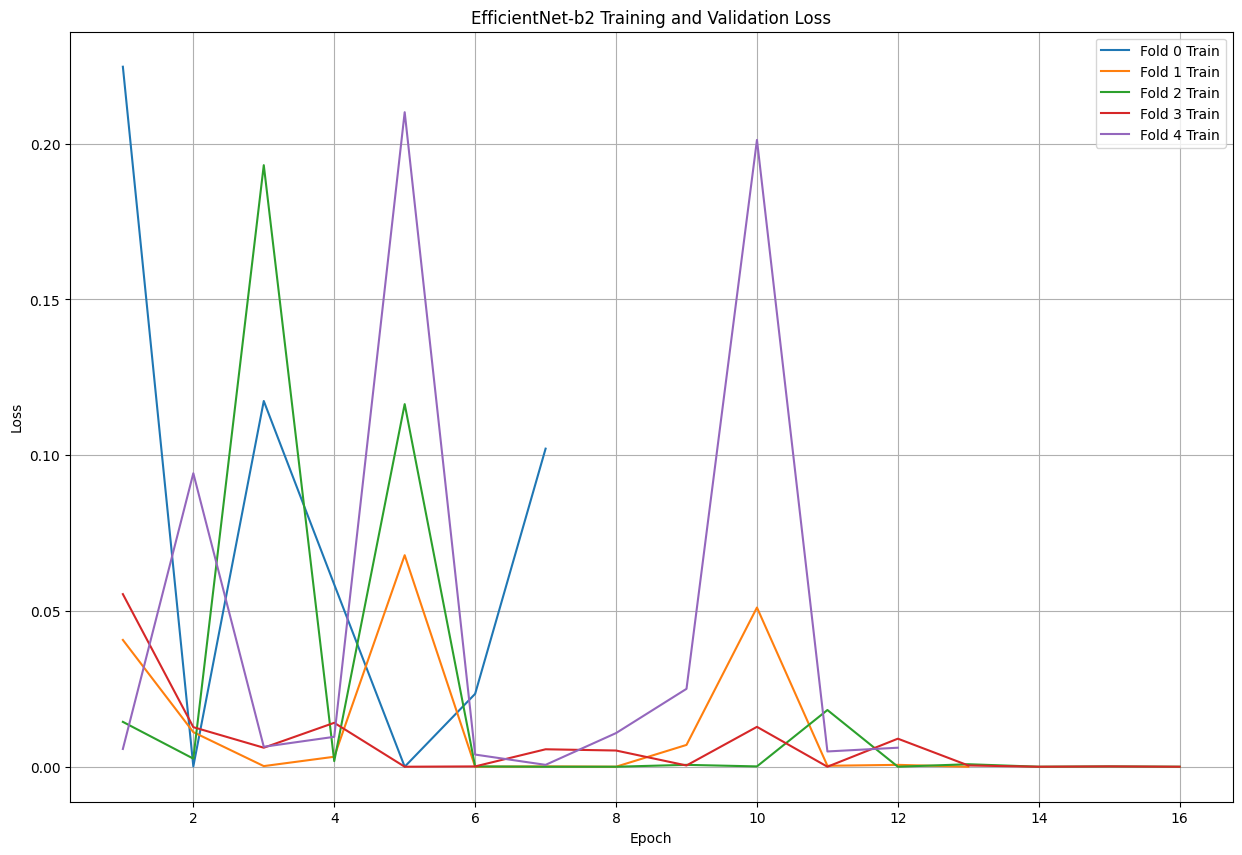

In [2]:
import matplotlib.pyplot as plt

# Define training and validation losses for each fold
train_losses_fold = [[0.2247, 0.0001, 0.1174, 0.0585, 0.0000, 0.0234, 0.1021],
                   [0.0407, 0.0111, 0.0002, 0.0032, 0.0679, 0.0000, 0.0001, 0.0000, 0.0070, 0.0511, 0.0003, 0.0006, 0.0000],
                   [0.0144, 0.0026, 0.1931, 0.0018, 0.1164, 0.0001, 0.0000, 0.0000, 0.0006, 0.0001, 0.0182, 0.0000, 0.0008, 0.0000, 0.0001, 0.0000],
                   [0.0554, 0.0127, 0.0061, 0.0141, 0.0000, 0.0001, 0.0056, 0.0052, 0.0004, 0.0128, 0.0000, 0.0090, 0.0004, 0.0000, 0.0001, 0.0000],
                   [0.0057, 0.0942, 0.0064, 0.0096, 0.2101, 0.0039, 0.0006, 0.0108, 0.0250, 0.2012, 0.0049, 0.0061]]

# Plotting the loss curves
plt.figure(figsize=(15, 10))

for i in range(len(train_losses_fold)):
    plt.plot(range(1, len(train_losses_fold[i]) + 1), train_losses_fold[i], label=f"Fold {i} Train")

plt.title('EfficientNet-b2 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
